In [115]:
import pandas as pd
import jsonpickle
import numpy as np
import matplotlib.pyplot as plt
import os, os.path
import dateutil.parser
from datetime import datetime

In [116]:
FILE_AS_ROOT = False
SELF_PATH = os.getcwd()#os.path.dirname(os.path.abspath(__file__))
PATH_TO_ROOT = os.path.join(SELF_PATH,'../../../../../../' if FILE_AS_ROOT else '../')
PATH_TO_JSON_STATES = os.path.join(PATH_TO_ROOT,'tagging_json_states/')
PATH_TO_JSON_STATES

'/home/namenai/Documents/GitKraken/Poststorm_Imagery/../tagging_json_states/'

In [117]:
TOTAL_JSON_STATES = (len([name for name in os.listdir(PATH_TO_JSON_STATES) if os.path.isfile(os.path.join(PATH_TO_JSON_STATES, name))]))
print(TOTAL_JSON_STATES)

892


In [118]:
def get_pickle(path_to_file):
    with open(path_to_file, 'r') as f:
        return jsonpickle.decode(f.read())

In [119]:
def how_many_tagged(pickle_file):
    
    done_tagging_count=len(pickle_file.finished_tagged_queue)
    tagged_but_not_done_count=0
    
    for image in pickle_file.pending_images_queue:
        if len(image.get_taggers()) > 0:
            tagged_but_not_done_count-=-1
    
    return pd.DataFrame([{ 
        'not_done':tagged_but_not_done_count,
        'done':done_tagging_count,
        'tagged_ratio': tagged_but_not_done_count/(tagged_but_not_done_count+done_tagging_count),
        'skipped':len(pickle_file.max_skipped_queue),
        'current':len(pickle_file.current_image),
        'tagged_ratio': tagged_but_not_done_count/(tagged_but_not_done_count+done_tagging_count+len(pickle_file.max_skipped_queue)+len(pickle_file.current_image))
     }])

In [120]:
def get_all_json_states(path_states):
    files = os.listdir(path_states)
    filter_by_type = [f for f in files if f[-4:] == 'json']
    filter_by_type.sort()
    return filter_by_type

In [121]:
files_json = get_all_json_states(PATH_TO_JSON_STATES)
print(files_json[1:4])

['assigner_state-root-2019-11-11T20_16_17.207157.json', 'assigner_state-root-2019-11-11T20_16_48.444302.json', 'assigner_state-root-2019-11-11T20_16_51.151759.json']


In [122]:
def get_tagged_ratio(files , skip=50):
    
    main_df = pd.DataFrame()
    
    for file in files[::skip]:
        path = f"{PATH_TO_JSON_STATES}/{file}"
        
        remove_name = file.split('assigner_state-root-')[-1]
        date_string = remove_name.split('.json')[0]
        removed_nano = date_string.split('.')[0].replace("_",":")
        time = dateutil.parser.parse(removed_nano).strftime('%s')
        time_df= pd.DataFrame([{'time':time,'name':date_string, 'date-time':datetime.fromtimestamp(int(time))}])    

        tag_df = how_many_tagged(get_pickle(path))
        
        combined_df = pd.concat([time_df,tag_df],axis=1, sort=False)
        main_df = pd.concat([combined_df,main_df],ignore_index=True)
        
    return main_df

In [123]:
df = get_tagged_ratio(files_json)
df_time_sort = df.sort_values(by=['time'])

In [124]:
df_time_sort.head()

,time,name,date-time,not_done,done,tagged_ratio
17,1573446648,2019-11-10T23_30_48.430349,2019-11-10 23:30:48,237,0,1.000000
16,1573522418,2019-11-11T20_33_38.520814,2019-11-11 20:33:38,216,20,0.915254
15,1573558785,2019-11-12T06_39_45.766386,2019-11-12 06:39:45,195,40,0.829787
14,1573559335,2019-11-12T06_48_55.595966,2019-11-12 06:48:55,175,61,0.741525
13,1573589450,2019-11-12T15_10_50.669186,2019-11-12 15:10:50,158,79,0.666667


In [128]:
df_time_sort[['tagged_ratio','time','date-time']].head()

,tagged_ratio,time,date-time
17,1.000000,1573446648,2019-11-10 23:30:48
16,0.915254,1573522418,2019-11-11 20:33:38
15,0.829787,1573558785,2019-11-12 06:39:45
14,0.741525,1573559335,2019-11-12 06:48:55
13,0.666667,1573589450,2019-11-12 15:10:50


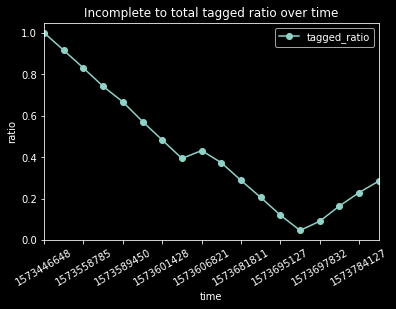

In [131]:
(df_time_sort[['tagged_ratio','time','date-time']]).plot(x='time', y='tagged_ratio', marker='o',rot=30)

plt.xlabel('time')
plt.ylabel('ratio')

plt.title("Incomplete to total tagged ratio over time")
plt.legend()
plt.show()

Write our findings to a .csv file

In [127]:
# get_tagged_ratio(files_json,1).to_csv('tagged_ratio_stats.csv')
# print('done')